# DRIVE Dataset - Comprehensive Exploratory Data Analysis

This notebook provides a comprehensive analysis of the **DRIVE** (Digital Retinal Images for Vessel Extraction) dataset.

## Dataset Overview
The DRIVE dataset is a widely used benchmark for retinal vessel segmentation. It consists of fundus images with corresponding manual segmentations and masks.

## Table of Contents
1. [Setup and Imports](#setup)
2. [Dataset Structure Analysis](#structure)
3. [Data Split Analysis](#splits)
4. [Image Properties](#properties)
5. [Mask Analysis](#masks)
6. [Vessel Segmentation Analysis](#vessels)
    "7. [Artery/Vein Segmentation Analysis](#av_analysis)\n",
8. [Statistical Analysis](#statistics)
9. [Data Quality Checks](#quality)
10. [Visualizations](#visualizations)
11. [Summary and Insights](#summary)

## 1. Setup and Imports <a name="setup"></a>

In [28]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from pathlib import Path
import cv2
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Set larger figure sizes by default
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

In [29]:
# Define paths
# Base directory (project root)
BASE_DIR = Path.cwd() / "../src/references/lwnet"

DRIVE_DIR = Path('../src/references/lwnet/data/DRIVE')
IMAGES_DIR = DRIVE_DIR / 'images'
MANUAL_DIR = DRIVE_DIR / 'manual'
MASK_DIR = DRIVE_DIR / 'mask'
MANUAL_AV_DIR = DRIVE_DIR / 'manual_av'
ZONEB_DIR = DRIVE_DIR / 'ZoneB_manual'

# CSV files
TRAIN_CSV = DRIVE_DIR / 'train.csv'
VAL_CSV = DRIVE_DIR / 'val.csv'
TEST_CSV = DRIVE_DIR / 'test.csv'
TEST_ALL_CSV = DRIVE_DIR / 'test_all.csv'
TRAIN_AV_CSV = DRIVE_DIR / 'train_av.csv'
VAL_AV_CSV = DRIVE_DIR / 'val_av.csv'
TEST_AV_CSV = DRIVE_DIR / 'test_av.csv'

print(f"Dataset base directory: {DRIVE_DIR}")
print(f"Dataset exists: {DRIVE_DIR.exists()}")

Dataset base directory: ../src/references/lwnet/data/DRIVE
Dataset exists: True


## 2. Dataset Structure Analysis <a name="structure"></a>

In [30]:
# List all directories and files
def list_directory_structure(path, level=0, max_files=5):
    """Display directory structure"""
    indent = "  " * level
    if path.is_dir():
        print(f"{indent}📁 {path.name}/")
        items = sorted(path.iterdir())
        dirs = [item for item in items if item.is_dir()]
        files = [item for item in items if item.is_file()]
        
        # Show directories
        for dir_item in dirs:
            list_directory_structure(dir_item, level + 1, max_files)
        
        # Show files (limited)
        if files:
            for file_item in files[:max_files]:
                size = file_item.stat().st_size
                size_str = f"{size/1024:.1f}KB" if size < 1024*1024 else f"{size/(1024*1024):.1f}MB"
                print(f"{indent}  📄 {file_item.name} ({size_str})")
            if len(files) > max_files:
                print(f"{indent}  ... and {len(files) - max_files} more files")

list_directory_structure(DRIVE_DIR)

📁 DRIVE/
  📁 DRIVE_AV_evalmasks/
    📁 Eroded_AV/
      📁 Centerline/
        📄 01_skeleton.png (14.6KB)
        📄 02_skeleton.png (14.3KB)
        📄 03_skeleton.png (14.4KB)
        📄 04_skeleton.png (14.1KB)
        📄 05_skeleton.png (15.0KB)
        ... and 15 more files
      📁 Centerline-2pix/
        📄 01_2pix.png (10.2KB)
        📄 02_2pix.png (10.1KB)
        📄 03_2pix.png (9.5KB)
        📄 04_2pix.png (9.0KB)
        📄 05_2pix.png (10.0KB)
        ... and 15 more files
    📁 Eroded_binary/
      📁 Centerline/
        📄 01_skeleton.png (13.3KB)
        📄 02_skeleton.png (13.4KB)
        📄 03_skeleton.png (13.3KB)
        📄 04_skeleton.png (12.6KB)
        📄 05_skeleton.png (13.6KB)
        ... and 15 more files
      📁 Centerline-2pix/
        📄 01_skeleton_2pix.png (8.3KB)
        📄 02_skeleton_2pix.png (8.5KB)
        📄 03_skeleton_2pix.png (7.6KB)
        📄 04_skeleton_2pix.png (7.3KB)
        📄 05_skeleton_2pix.png (8.1KB)
        ... and 15 more files
    📁 Predicted_AV/
 


FILE COUNTS BY DIRECTORY
         Directory  File Count
            Images          40
Manual Annotations          40
             Masks          40
         Manual AV          40
     Zone B Manual          20


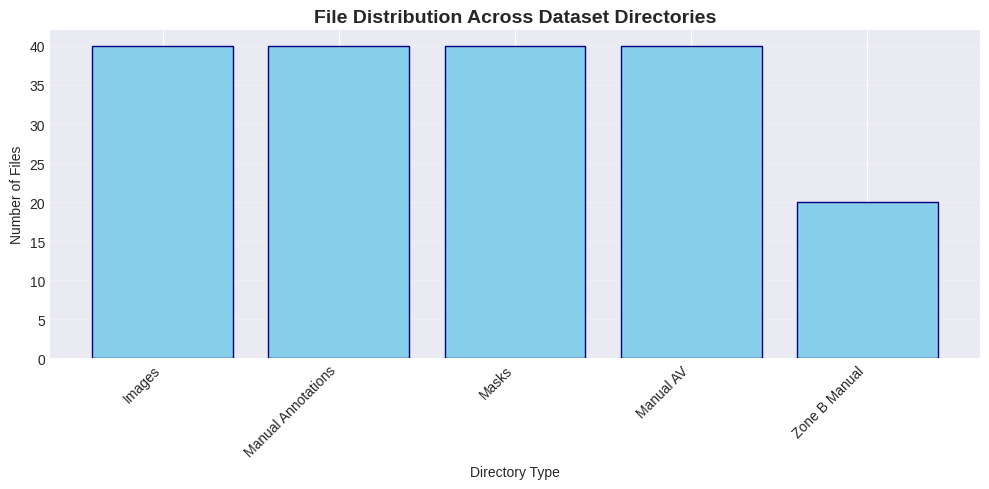

In [31]:
# Count files in each directory
file_counts = {
    'Images': len(list(IMAGES_DIR.glob('*.*'))),
    'Manual Annotations': len(list(MANUAL_DIR.glob('*.*'))),
    'Masks': len(list(MASK_DIR.glob('*.*'))),
    'Manual AV': len(list(MANUAL_AV_DIR.glob('*.*'))),
    'Zone B Manual': len(list(ZONEB_DIR.glob('*.*')))
}

# Create DataFrame for better display
df_counts = pd.DataFrame(list(file_counts.items()), columns=['Directory', 'File Count'])
print("\n" + "="*50)
print("FILE COUNTS BY DIRECTORY")
print("="*50)
print(df_counts.to_string(index=False))

# Visualize
plt.figure(figsize=(10, 5))
plt.bar(df_counts['Directory'], df_counts['File Count'], color='skyblue', edgecolor='navy')
plt.xlabel('Directory Type')
plt.ylabel('Number of Files')
plt.title('File Distribution Across Dataset Directories', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## 3. Data Split Analysis <a name="splits"></a>

In [32]:
# Load CSV files
df_train = pd.read_csv(TRAIN_CSV)
df_val = pd.read_csv(VAL_CSV)
df_test = pd.read_csv(TEST_CSV)
df_test_all = pd.read_csv(TEST_ALL_CSV)

print("\n" + "="*50)
print("DATA SPLIT STATISTICS")
print("="*50)
print(f"Training samples: {len(df_train)}")
print(f"Validation samples: {len(df_val)}")
print(f"Test samples: {len(df_test)}")
print(f"Test (all) samples: {len(df_test_all)}")
print(f"Total samples: {len(df_train) + len(df_val) + len(df_test)}")

# Calculate percentages
total = len(df_train) + len(df_val) + len(df_test)
train_pct = (len(df_train) / total) * 100
val_pct = (len(df_val) / total) * 100
test_pct = (len(df_test) / total) * 100

print(f"\nSplit Ratio:")
print(f"  Train: {train_pct:.1f}%")
print(f"  Val:   {val_pct:.1f}%")
print(f"  Test:  {test_pct:.1f}%")


DATA SPLIT STATISTICS
Training samples: 16
Validation samples: 4
Test samples: 20
Test (all) samples: 40
Total samples: 40

Split Ratio:
  Train: 40.0%
  Val:   10.0%
  Test:  50.0%


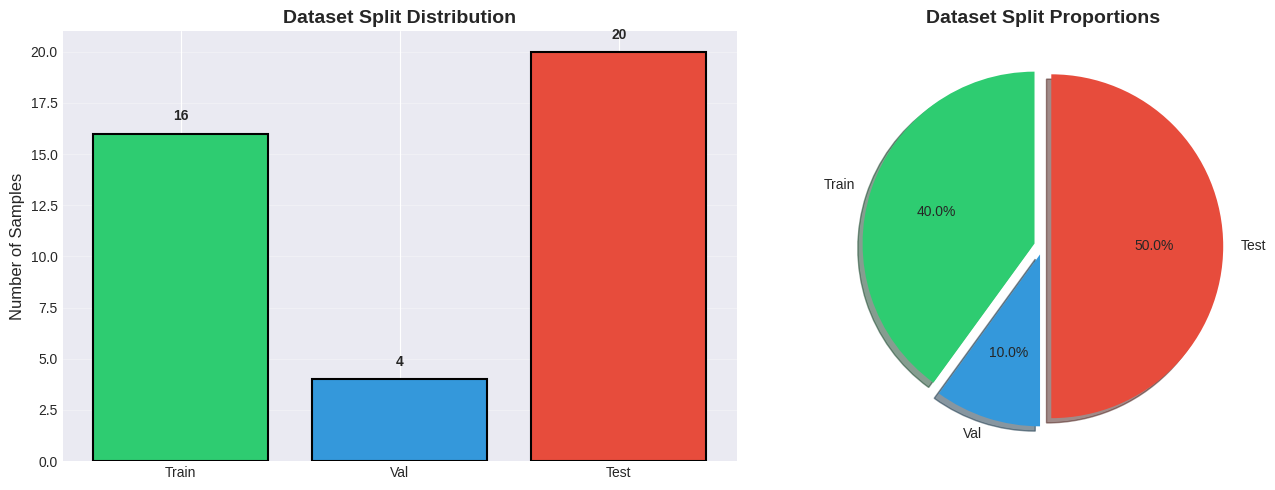

In [33]:
# Visualize data splits
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot
splits = ['Train', 'Val', 'Test']
counts = [len(df_train), len(df_val), len(df_test)]
colors = ['#2ecc71', '#3498db', '#e74c3c']

axes[0].bar(splits, counts, color=colors, edgecolor='black', linewidth=1.5)
axes[0].set_ylabel('Number of Samples', fontsize=12)
axes[0].set_title('Dataset Split Distribution', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Add count labels on bars
for i, (split, count) in enumerate(zip(splits, counts)):
    axes[0].text(i, count + 0.5, str(count), ha='center', va='bottom', fontweight='bold')

# Pie chart
axes[1].pie(counts, labels=splits, autopct='%1.1f%%', startangle=90, 
            colors=colors, explode=(0.05, 0.05, 0.05), shadow=True)
axes[1].set_title('Dataset Split Proportions', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

In [34]:
# Display sample rows from each split
print("\n" + "="*80)
print("SAMPLE DATA FROM TRAIN SET (First 3 rows)")
print("="*80)
print(df_train.head(3).to_string(index=False))

print("\n" + "="*80)
print("SAMPLE DATA FROM TEST SET (First 3 rows)")
print("="*80)
print(df_test.head(3).to_string(index=False))


SAMPLE DATA FROM TRAIN SET (First 3 rows)
                         im_paths                         gt_paths                  mask_paths
data/DRIVE/images/21_training.tif data/DRIVE/manual/21_manual1.gif data/DRIVE/mask/21_mask.gif
data/DRIVE/images/22_training.tif data/DRIVE/manual/22_manual1.gif data/DRIVE/mask/22_mask.gif
data/DRIVE/images/23_training.tif data/DRIVE/manual/23_manual1.gif data/DRIVE/mask/23_mask.gif

SAMPLE DATA FROM TEST SET (First 3 rows)
                     im_paths                         gt_paths                  mask_paths
data/DRIVE/images/01_test.tif data/DRIVE/manual/01_manual1.gif data/DRIVE/mask/01_mask.gif
data/DRIVE/images/02_test.tif data/DRIVE/manual/02_manual1.gif data/DRIVE/mask/02_mask.gif
data/DRIVE/images/03_test.tif data/DRIVE/manual/03_manual1.gif data/DRIVE/mask/03_mask.gif


In [35]:
df_train_av = pd.read_csv(TRAIN_AV_CSV)
df_val_av = pd.read_csv(VAL_AV_CSV)
df_test_av = pd.read_csv(TEST_AV_CSV)

df_train_all = df_train.copy()
df_train_all["gt_paths_av"] = df_train_av["gt_paths"]
df_val_all = df_val.copy()
df_val_all["gt_paths_av"] = df_val_av["gt_paths"]
df_test_all = df_test.copy()
df_test_all["gt_paths_av"] = df_test_av["gt_paths"]

# Display sample rows from each split
print("\n" + "="*80)
print("SAMPLE DATA FROM TRAIN SET (First 3 rows)")
print("="*80)
print(df_train_all.head(3).to_string(index=False))

print("\n" + "="*80)
print("SAMPLE DATA FROM VAL SET (First 3 rows)")
print("="*80)
print(df_val_all.head(3).to_string(index=False))

print("\n" + "="*80)
print("SAMPLE DATA FROM TEST SET (First 3 rows)")
print("="*80)
print(df_test_all.head(3).to_string(index=False))


SAMPLE DATA FROM TRAIN SET (First 3 rows)
                         im_paths                         gt_paths                  mask_paths                          gt_paths_av
data/DRIVE/images/21_training.tif data/DRIVE/manual/21_manual1.gif data/DRIVE/mask/21_mask.gif data/DRIVE/manual_av/21_training.png
data/DRIVE/images/22_training.tif data/DRIVE/manual/22_manual1.gif data/DRIVE/mask/22_mask.gif data/DRIVE/manual_av/22_training.png
data/DRIVE/images/23_training.tif data/DRIVE/manual/23_manual1.gif data/DRIVE/mask/23_mask.gif data/DRIVE/manual_av/23_training.png

SAMPLE DATA FROM VAL SET (First 3 rows)
                         im_paths                         gt_paths                  mask_paths                          gt_paths_av
data/DRIVE/images/37_training.tif data/DRIVE/manual/37_manual1.gif data/DRIVE/mask/37_mask.gif data/DRIVE/manual_av/37_training.png
data/DRIVE/images/38_training.tif data/DRIVE/manual/38_manual1.gif data/DRIVE/mask/38_mask.gif data/DRIVE/manual_av/38_train

## 4. Image Properties <a name="properties"></a>

In [53]:
# Analyze image properties
def analyze_images(df, base_dir):
    """Analyze properties of images"""
    results = []
    
    for idx, row in df.iterrows():
        # Construct full path - CSV has relative paths from project root
        img_path = base_dir / row['im_paths']
        
        # Open image
        img = Image.open(img_path)
        img_array = np.array(img)
        
        # Extract properties
        properties = {
            'filename': Path(img_path).name,
            'width': img.width,
            'height': img.height,
            'mode': img.mode,
            'channels': len(img_array.shape) if len(img_array.shape) == 2 else img_array.shape[2],
            'dtype': str(img_array.dtype),
            'min_value': img_array.min(),
            'max_value': img_array.max(),
            'mean_value': img_array.mean(),
            'std_value': img_array.std(),
            'file_size_kb': Path(img_path).stat().st_size / 1024
        }
        results.append(properties)
    
    return pd.DataFrame(results)

# Analyze train images
print("Analyzing training images...")
df_train_img_props = analyze_images(df_train, BASE_DIR)

# Analyze test images
print("Analyzing val images...")
df_val_img_props = analyze_images(df_val, BASE_DIR)

# Analyze test images
print("Analyzing test images...")
df_test_img_props = analyze_images(df_test, BASE_DIR)

# Combine for overall statistics
df_all_img_props = pd.concat([df_train_img_props, df_val_img_props, df_test_img_props], ignore_index=True)

print("\n" + "="*80)
print("IMAGE PROPERTIES SUMMARY")
print("="*80)
print(df_all_img_props[['width', 'height', 'channels', 'min_value', 'max_value', 'mean_value', 'std_value']].describe())

Analyzing training images...
Analyzing val images...
Analyzing test images...

IMAGE PROPERTIES SUMMARY
       width  height  channels  min_value   max_value  mean_value  std_value
count   40.0    40.0      40.0       40.0   40.000000   40.000000  40.000000
mean   565.0   584.0       3.0        0.0  253.250000   79.695394  68.922233
std      0.0     0.0       0.0        0.0    6.491612   12.459480  10.907125
min    565.0   584.0       3.0        0.0  226.000000   53.151897  47.732805
25%    565.0   584.0       3.0        0.0  255.000000   72.872837  62.090199
50%    565.0   584.0       3.0        0.0  255.000000   81.733450  71.769516
75%    565.0   584.0       3.0        0.0  255.000000   89.326267  76.523107
max    565.0   584.0       3.0        0.0  255.000000  100.446954  91.635417


In [54]:
# Check if all images have the same dimensions
unique_dims = df_all_img_props[['width', 'height']].drop_duplicates()

print("\n" + "="*50)
print("UNIQUE IMAGE DIMENSIONS")
print("="*50)
print(unique_dims.to_string(index=False))

if len(unique_dims) == 1:
    print("\n✓ All images have consistent dimensions!")
else:
    print("\n⚠ Images have different dimensions!")


UNIQUE IMAGE DIMENSIONS
 width  height
   565     584

✓ All images have consistent dimensions!


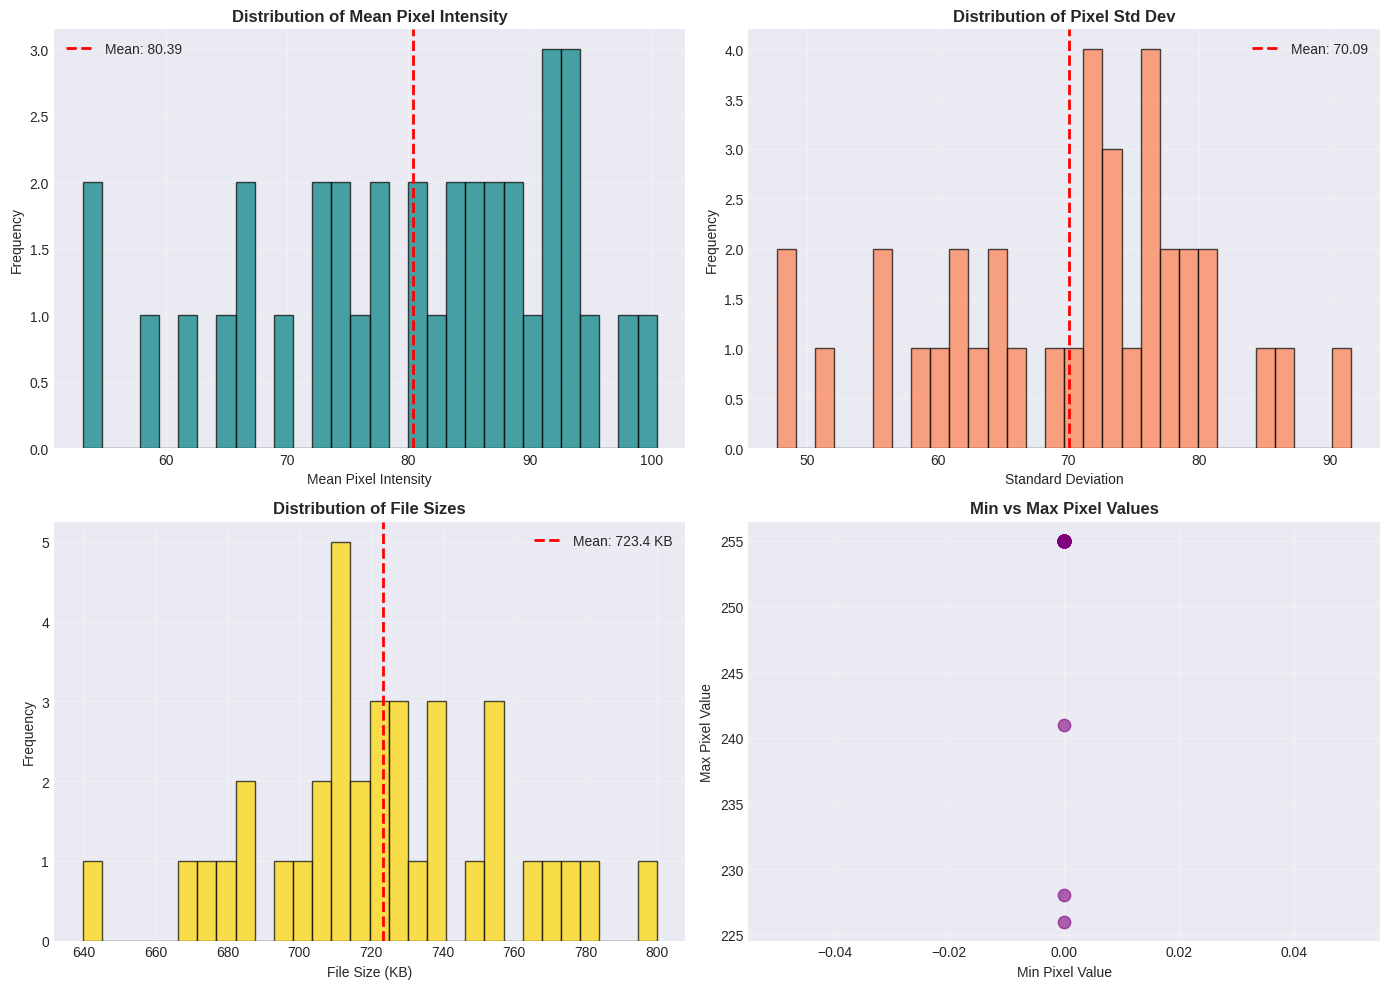

In [38]:
# Visualize intensity distributions
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Mean intensity
axes[0, 0].hist(df_all_img_props['mean_value'], bins=30, color='teal', edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Mean Pixel Intensity')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Mean Pixel Intensity', fontweight='bold')
axes[0, 0].axvline(df_all_img_props['mean_value'].mean(), color='red', linestyle='--', 
                   linewidth=2, label=f"Mean: {df_all_img_props['mean_value'].mean():.2f}")
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Standard deviation
axes[0, 1].hist(df_all_img_props['std_value'], bins=30, color='coral', edgecolor='black', alpha=0.7)
axes[0, 1].set_xlabel('Standard Deviation')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Distribution of Pixel Std Dev', fontweight='bold')
axes[0, 1].axvline(df_all_img_props['std_value'].mean(), color='red', linestyle='--', 
                   linewidth=2, label=f"Mean: {df_all_img_props['std_value'].mean():.2f}")
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# File sizes
axes[1, 0].hist(df_all_img_props['file_size_kb'], bins=30, color='gold', edgecolor='black', alpha=0.7)
axes[1, 0].set_xlabel('File Size (KB)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Distribution of File Sizes', fontweight='bold')
axes[1, 0].axvline(df_all_img_props['file_size_kb'].mean(), color='red', linestyle='--', 
                   linewidth=2, label=f"Mean: {df_all_img_props['file_size_kb'].mean():.1f} KB")
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Min vs Max values scatter
axes[1, 1].scatter(df_all_img_props['min_value'], df_all_img_props['max_value'], alpha=0.6, s=80, c='purple')
axes[1, 1].set_xlabel('Min Pixel Value')
axes[1, 1].set_ylabel('Max Pixel Value')
axes[1, 1].set_title('Min vs Max Pixel Values', fontweight='bold')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Mask Analysis <a name="masks"></a>

In [56]:
# Analyze masks
def analyze_masks(df, base_dir):
    """Analyze properties of masks"""
    results = []
    
    for idx, row in df.iterrows():
        mask_path = base_dir / row['mask_paths']
        mask = Image.open(mask_path)
        mask_array = np.array(mask)
        
        # Normalize to binary if needed
        mask_binary = (mask_array > 0).astype(np.uint8)
        
        properties = {
            'filename': Path(mask_path).name,
            'width': mask.width,
            'height': mask.height,
            'total_pixels': mask.width * mask.height,
            'roi_pixels': mask_binary.sum(),
            'roi_percentage': (mask_binary.sum() / (mask.width * mask.height)) * 100,
            'background_pixels': (mask.width * mask.height) - mask_binary.sum(),
        }
        results.append(properties)
    
    return pd.DataFrame(results)

# Analyze masks
print("Analyzing masks...")
df_train_mask_props = analyze_masks(df_train, BASE_DIR)
df_val_mask_props = analyze_masks(df_val, BASE_DIR)
df_test_mask_props = analyze_masks(df_test, BASE_DIR)
df_all_mask_props = pd.concat([df_train_mask_props, df_val_mask_props, df_test_mask_props], ignore_index=True)

print("\n" + "="*80)
print("MASK PROPERTIES SUMMARY")
print("="*80)
print(df_all_mask_props[['total_pixels', 'roi_pixels', 'roi_percentage', 'background_pixels']].describe())

Analyzing masks...

MASK PROPERTIES SUMMARY
       total_pixels     roi_pixels  roi_percentage  background_pixels
count          40.0      40.000000       40.000000          40.000000
mean       329960.0  226978.725000       68.789770      102981.275000
std             0.0     992.593727        0.300822         992.593727
min        329960.0  224377.000000       68.001273      101773.000000
25%        329960.0  226462.500000       68.633319      102296.250000
50%        329960.0  227391.000000       68.914717      102569.000000
75%        329960.0  227663.750000       68.997378      103497.500000
max        329960.0  228187.000000       69.155958      105583.000000


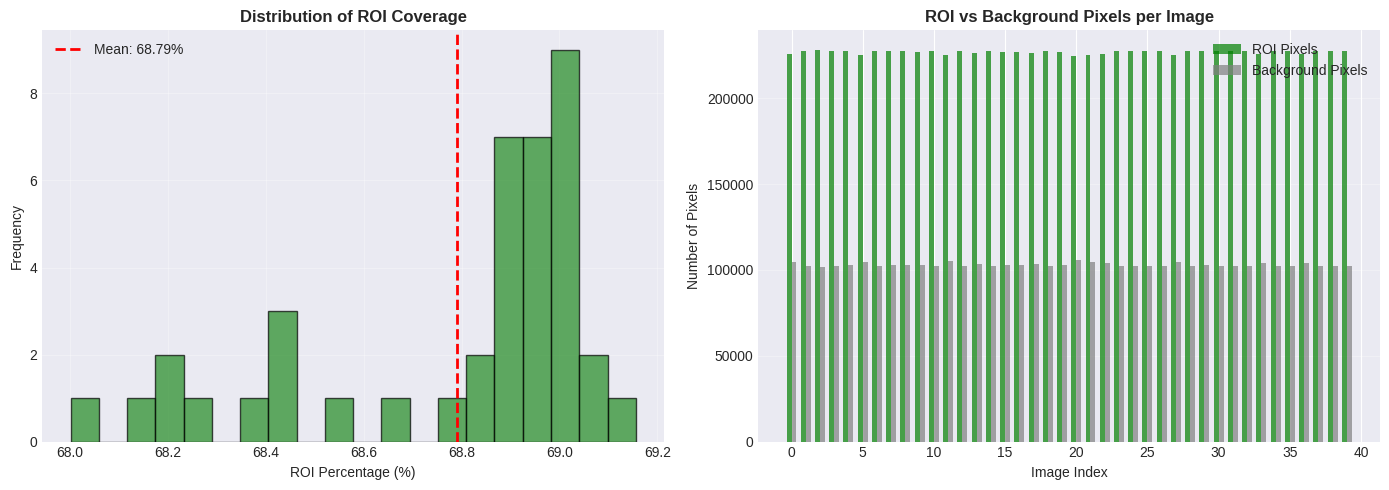

In [57]:
# Visualize mask properties
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ROI percentage distribution
axes[0].hist(df_all_mask_props['roi_percentage'], bins=20, color='forestgreen', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('ROI Percentage (%)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of ROI Coverage', fontweight='bold')
axes[0].axvline(df_all_mask_props['roi_percentage'].mean(), color='red', linestyle='--', 
                linewidth=2, label=f"Mean: {df_all_mask_props['roi_percentage'].mean():.2f}%")
axes[0].legend()
axes[0].grid(alpha=0.3)

# ROI vs Background pixels
x = np.arange(len(df_all_mask_props))
width = 0.35
axes[1].bar(x - width/2, df_all_mask_props['roi_pixels'], width, label='ROI Pixels', color='green', alpha=0.7)
axes[1].bar(x + width/2, df_all_mask_props['background_pixels'], width, label='Background Pixels', color='gray', alpha=0.7)
axes[1].set_xlabel('Image Index')
axes[1].set_ylabel('Number of Pixels')
axes[1].set_title('ROI vs Background Pixels per Image', fontweight='bold')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Vessel Segmentation Analysis <a name="vessels"></a>

In [111]:
# Analyze vessel segmentation masks
def analyze_vessel_segmentation(df, base_dir):
    """Analyze vessel segmentation properties"""
    results = []
    
    for idx, row in df.iterrows():
        gt_path = base_dir / row['gt_paths']
        gt = Image.open(gt_path)
        gt_array = np.array(gt)
        
        # Binary vessel mask
        vessel_mask = (gt_array > 0).astype(np.uint8)
        
        properties = {
            'filename': Path(gt_path).name,
            'total_pixels': gt.width * gt.height,
            'vessel_pixels': vessel_mask.sum(),
            'vessel_percentage': (vessel_mask.sum() / (gt.width * gt.height)) * 100,
            'background_pixels': (gt.width * gt.height) - vessel_mask.sum(),
        }
        results.append(properties)
    
    return pd.DataFrame(results)

# Analyze vessel segmentations
print("Analyzing vessel segmentations...")
df_train_vessel = analyze_vessel_segmentation(df_train, BASE_DIR)
df_val_vessel = analyze_vessel_segmentation(df_val, BASE_DIR)
df_test_vessel = analyze_vessel_segmentation(df_test, BASE_DIR)
df_all_vessel = pd.concat([df_train_vessel, df_val_vessel, df_test_vessel], ignore_index=True)

print("\n" + "="*80)
print("VESSEL SEGMENTATION SUMMARY")
print("="*80)
df_all_vessel[['total_pixels', 'vessel_pixels', 'vessel_percentage']].describe()

Analyzing vessel segmentations...

VESSEL SEGMENTATION SUMMARY


,total_pixels,vessel_pixels,vessel_percentage
count,40.0,40.000000,40.000000
mean,329960.0,28689.000000,8.694690
std,0.0,3567.641956,1.081235
min,329960.0,19898.000000,6.030428
25%,329960.0,26727.250000,8.100149
50%,329960.0,28483.500000,8.632410
75%,329960.0,30493.500000,9.241575
max,329960.0,38229.000000,11.585950


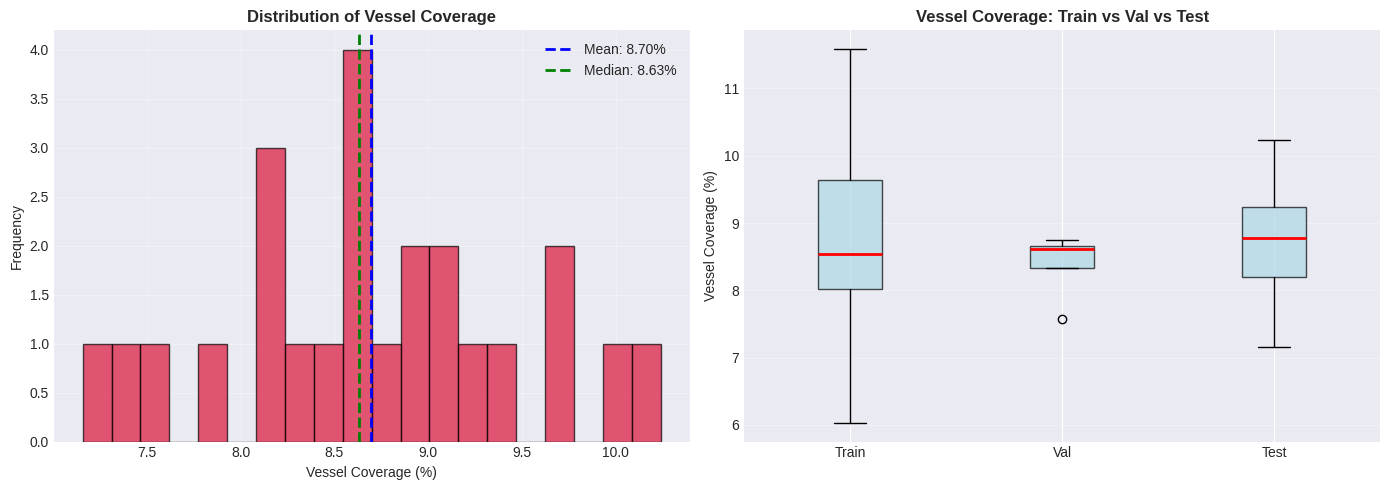

In [110]:
# Visualize vessel statistics
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Vessel percentage distribution
axes[0].hist(df_all_vessel['vessel_percentage'], bins=20, color='crimson', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Vessel Coverage (%)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Vessel Coverage', fontweight='bold')
axes[0].axvline(df_all_vessel['vessel_percentage'].mean(), color='blue', linestyle='--', 
                linewidth=2, label=f"Mean: {df_all_vessel['vessel_percentage'].mean():.2f}%")
axes[0].axvline(df_all_vessel['vessel_percentage'].median(), color='green', linestyle='--', 
                linewidth=2, label=f"Median: {df_all_vessel['vessel_percentage'].median():.2f}%")
axes[0].legend()
axes[0].grid(alpha=0.3)

# Box plot for vessel coverage
axes[1].boxplot([df_train_vessel['vessel_percentage'], df_val_vessel['vessel_percentage'], df_test_vessel['vessel_percentage']], 
                labels=['Train', 'Val', 'Test'], patch_artist=True,
                boxprops=dict(facecolor='lightblue', alpha=0.7),
                medianprops=dict(color='red', linewidth=2))
axes[1].set_ylabel('Vessel Coverage (%)')
axes[1].set_title('Vessel Coverage: Train vs Val vs Test', fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Artery/Vein Segmentation Analysis <a name="av_analysis"></a>

In this section, we analyze the Artery/Vein (AV) ground truth annotations. 
Based on color analysis of the masks:
- **Artery**: Red color (RGB: 255, 0, 0)
- **Vein**: Blue color (RGB: 0, 0, 255)
- **Overlap/Uncertain**: Green color (RGB: 0, 255, 0)
- **Other**: White (likely optic disc or artifacts)

In [93]:
def analyze_av_masks(df, base_dir):
    """Analyze Artery/Vein masks"""
    results = []
    
    for idx, row in df.iterrows():
        # Handle potential path differences
        rel_path = row['gt_paths'].replace('data/DRIVE/', '')
        gt_path = base_dir / rel_path
        
        if gt_path.exists():
            # Open image and convert to RGB
            mask = Image.open(gt_path).convert('RGB')
            mask_arr = np.array(mask)
            
            # Calculate total pixels
            total_pixels = mask_arr.shape[0] * mask_arr.shape[1]
            
            # Identify Colors
            # Red: Artery ([255, 0, 0])
            is_red = (mask_arr[:, :, 0] > 200) & (mask_arr[:, :, 1] < 50) & (mask_arr[:, :, 2] < 50)
            # Blue: Vein ([0, 0, 255])
            is_blue = (mask_arr[:, :, 2] > 200) & (mask_arr[:, :, 0] < 50) & (mask_arr[:, :, 1] < 50)
            # Green: Overlap/Uncertain ([0, 255, 0])
            is_green = (mask_arr[:, :, 1] > 200) & (mask_arr[:, :, 0] < 50) & (mask_arr[:, :, 2] < 50)
            # White: Optic Disc/Artifact ([255, 255, 255])
            is_white = (mask_arr[:, :, 0] > 200) & (mask_arr[:, :, 1] > 200) & (mask_arr[:, :, 2] > 200)
            
            artery_pixels = np.sum(is_red)
            vein_pixels = np.sum(is_blue)
            overlap_pixels = np.sum(is_green)
            other_pixels = np.sum(is_white)
            
            # Anything else non-black
            is_vessel = np.any(mask_arr > 20, axis=2)
            unknown_pixels = np.sum(is_vessel & (~is_red) & (~is_blue) & (~is_green) & (~is_white))
            
            results.append({
                'filename': gt_path.name,
                'artery_pixels': artery_pixels,
                'vein_pixels': vein_pixels,
                'overlap_pixels': overlap_pixels,
                'other_pixels': other_pixels + unknown_pixels,
                'artery_ratio': artery_pixels / total_pixels * 100,
                'vein_ratio': vein_pixels / total_pixels * 100,
                'av_ratio': artery_pixels / vein_pixels * 100 if vein_pixels > 0 else np.nan
            })
            
    return pd.DataFrame(results)

df_av_stats_val = analyze_av_masks(df_val_av, DRIVE_DIR)
df_av_stats_test = analyze_av_masks(df_test_av, DRIVE_DIR)

# Combine for summary
df_av_stats_all = pd.concat([df_av_stats_val, df_av_stats_test])

print("\n" + "="*50)
print("ARTERY/VEIN SEGMENTATION SUMMARY")
print("="*50)
df_av_stats_all.describe()


ARTERY/VEIN SEGMENTATION SUMMARY


,artery_pixels,vein_pixels,overlap_pixels,other_pixels,artery_ratio,vein_ratio,av_ratio
count,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,20.000000
mean,9858.208333,11992.333333,866.791667,5048.750000,2.987698,3.634481,83.015597
std,4853.476280,5762.940151,456.884438,10364.074254,1.470929,1.746557,14.224452
min,0.000000,0.000000,0.000000,99.000000,0.000000,0.000000,50.465180
25%,9371.000000,11651.250000,753.000000,376.250000,2.840041,3.531110,75.486597
50%,11593.500000,14395.500000,961.000000,493.000000,3.513608,4.362802,82.507203
75%,12917.750000,15492.250000,1226.000000,1087.000000,3.914944,4.695190,91.208350
max,15159.000000,17365.000000,1434.000000,28781.000000,4.594193,5.262759,112.274806


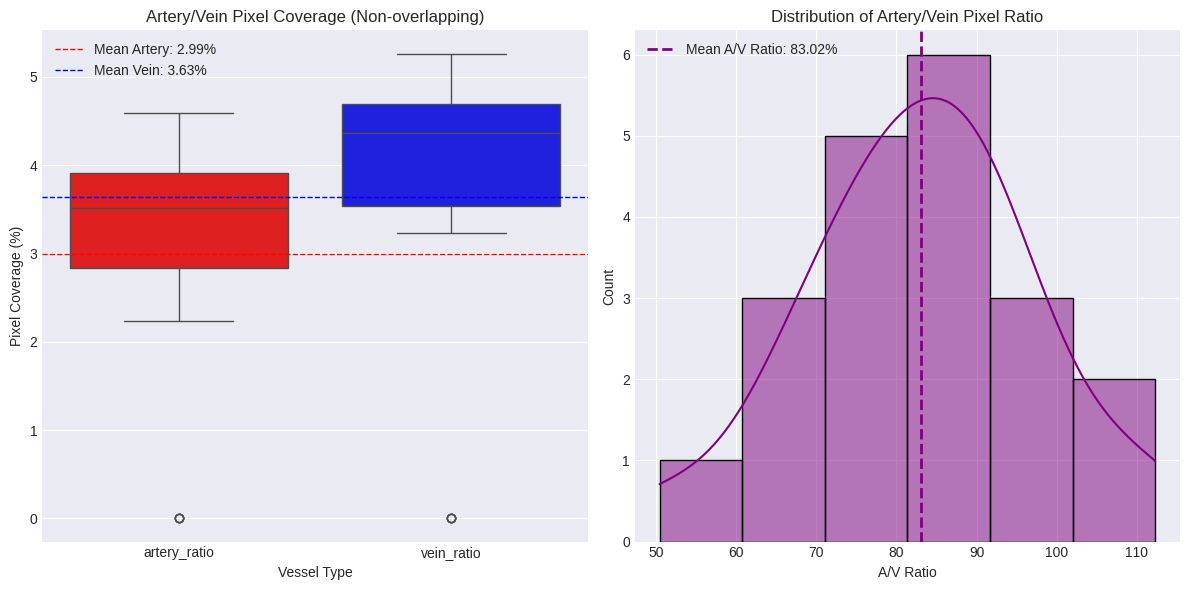

In [112]:
# Visualize A/V Ratios
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
data_melted = df_av_stats_all[['artery_ratio', 'vein_ratio']].melt(var_name='Vessel Type', value_name='Pixel Coverage (%)')
sns.boxplot(x='Vessel Type', y='Pixel Coverage (%)', data=data_melted, palette=['red', 'blue'])
plt.title('Artery/Vein Pixel Coverage (Non-overlapping)')

mean_artery_ratio = df_av_stats_all['artery_ratio'].mean()
mean_vein_ratio = df_av_stats_all['vein_ratio'].mean()
plt.axhline(mean_artery_ratio, color='red', linestyle='--', linewidth=1, label=f'Mean Artery: {mean_artery_ratio:.2f}%')
plt.axhline(mean_vein_ratio, color='blue', linestyle='--', linewidth=1, label=f'Mean Vein: {mean_vein_ratio:.2f}%')
plt.legend()

plt.subplot(1, 2, 2)
sns.histplot(df_av_stats_all['av_ratio'], kde=True, color='purple')
plt.title('Distribution of Artery/Vein Pixel Ratio')
plt.xlabel('A/V Ratio')

mean_av_ratio = df_av_stats_all['av_ratio'].mean()
plt.axvline(mean_av_ratio, color='purple', linestyle='--', linewidth=2, label=f'Mean A/V Ratio: {mean_av_ratio:.2f}%')
plt.legend()

plt.tight_layout()
plt.show()

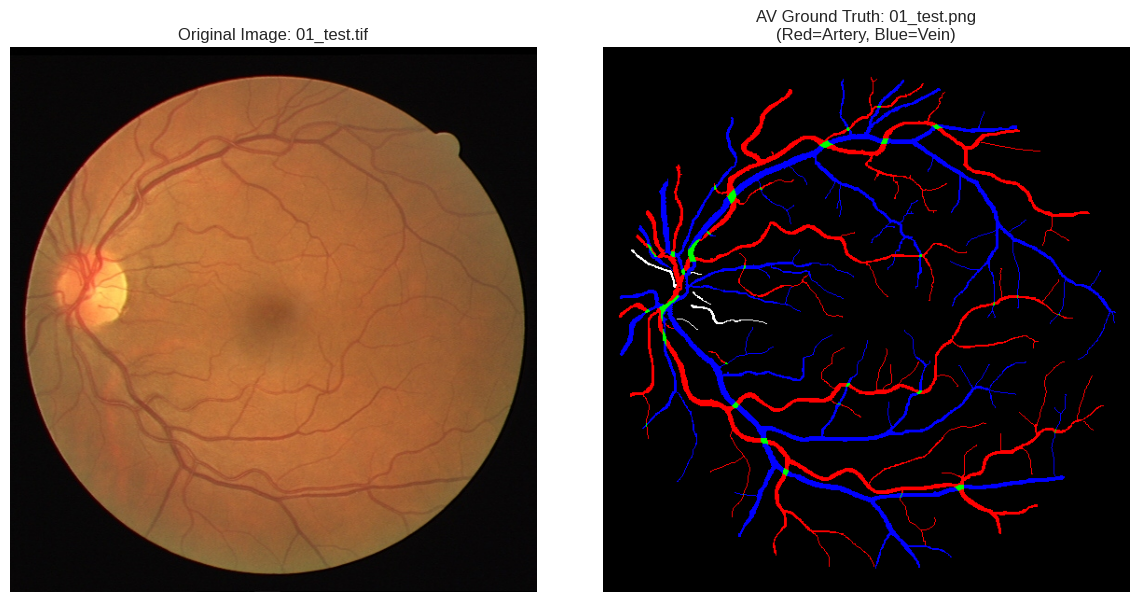

In [113]:
# Visualize Sample AV Mask
def visualize_av_sample(df, base_dir, index=0):
    if df.empty:
        return
    row = df.iloc[index]
    im_rel = row['im_paths'].replace('data/DRIVE/', '')
    gt_rel = row['gt_paths'].replace('data/DRIVE/', '')
    
    im_path = base_dir / im_rel
    gt_path = base_dir / gt_rel
    
    if im_path.exists() and gt_path.exists():
        img = Image.open(im_path)
        mask = Image.open(gt_path).convert('RGB')
        
        plt.figure(figsize=(12, 6))
        
        plt.subplot(1, 2, 1)
        plt.imshow(img)
        plt.title(f"Original Image: {im_path.name}")
        plt.axis('off')
        
        plt.subplot(1, 2, 2)
        plt.imshow(mask)
        plt.title(f"AV Ground Truth: {gt_path.name}\n(Red=Artery, Blue=Vein)")
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()

visualize_av_sample(df_test_av, DRIVE_DIR, index=0)

## 8. Statistical Analysis <a name="statistics"></a>

In [114]:
# Comprehensive statistics
print("\n" + "="*80)
print("COMPREHENSIVE DATASET STATISTICS")
print("="*80)

stats = {
    'Total Images': len(df_all_img_props),
    'Training Images': len(df_train),
    'Validation Images': len(df_val),
    'Test Images': len(df_test),
    'Image Dimensions': f"{df_all_img_props['width'].iloc[0]}x{df_all_img_props['height'].iloc[0]}",
    'Average Image Size (KB)': f"{df_all_img_props['file_size_kb'].mean():.2f}",
    'Average ROI Coverage (%)': f"{df_all_mask_props['roi_percentage'].mean():.2f}",
    'Average Vessel Coverage (%)': f"{df_all_vessel['vessel_percentage'].mean():.2f}",
    'Average Artery Coverage (%)': f"{df_av_stats_all['artery_ratio'].mean():.2f}",
    'Average Vein Coverage (%)': f"{df_av_stats_all['vein_ratio'].mean():.2f}",
    'Average Pixel Intensity': f"{df_all_img_props['mean_value'].mean():.2f}",
    'Average Pixel Std Dev': f"{df_all_img_props['std_value'].mean():.2f}",
}

for key, value in stats.items():
    print(f"{key:.<40} {value}")


COMPREHENSIVE DATASET STATISTICS
Total Images............................ 40
Training Images......................... 16
Validation Images....................... 4
Test Images............................. 20
Image Dimensions........................ 565x584
Average Image Size (KB)................. 723.20
Average ROI Coverage (%)................ 68.79
Average Vessel Coverage (%)............. 8.69
Average Artery Coverage (%)............. 2.99
Average Vein Coverage (%)............... 3.63
Average Pixel Intensity................. 79.70
Average Pixel Std Dev................... 68.92



CLASS IMBALANCE ANALYSIS
Average Vessel Pixels: 8.69%
Average Background Pixels: 91.31%
Imbalance Ratio (Background:Vessel): 10.50:1


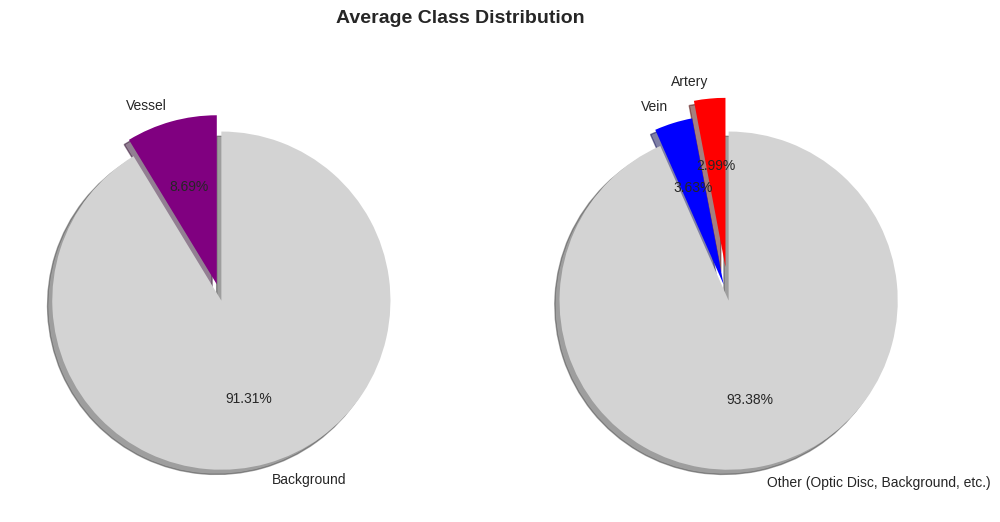

In [108]:
# Class imbalance analysis
avg_vessel_pct = df_all_vessel['vessel_percentage'].mean()
avg_background_pct = 100 - avg_vessel_pct

avg_artery_pct = df_av_stats_all['artery_ratio'].mean()
avg_vein_pct = df_av_stats_all['vein_ratio'].mean()
avg_other_pct = 100 - avg_artery_pct - avg_vein_pct

print("\n" + "="*80)
print("CLASS IMBALANCE ANALYSIS")
print("="*80)
print(f"Average Vessel Pixels: {avg_vessel_pct:.2f}%")
print(f"Average Background Pixels: {avg_background_pct:.2f}%")
print(f"Imbalance Ratio (Background:Vessel): {avg_background_pct/avg_vessel_pct:.2f}:1")

# Visualize class imbalance
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.pie([avg_vessel_pct, avg_background_pct], 
        labels=['Vessel', 'Background'],
        autopct='%1.2f%%',
        colors=['purple', 'lightgray'],
        explode=(0.1, 0),
        shadow=True,
        startangle=90)

plt.subplot(1, 2, 2)
plt.pie([avg_artery_pct, avg_vein_pct, avg_other_pct], 
        labels=['Artery', 'Vein', 'Other (Optic Disc, Background, etc.)'],
        autopct='%1.2f%%',
        colors=['red', 'blue', 'lightgray'],
        explode=(0.2, 0.1, 0),
        shadow=True,
        startangle=90)

plt.suptitle('Average Class Distribution', fontsize=14, fontweight='bold')
plt.show()

## 9. Data Quality Checks <a name="quality"></a>

In [115]:
# Quality checks
print("\n" + "="*80)
print("DATA QUALITY CHECKS")
print("="*80)

# Check 1: Consistent dimensions
all_same_dims = (df_all_img_props['width'].nunique() == 1) and (df_all_img_props['height'].nunique() == 1)
print(f"✓ All images have consistent dimensions: {all_same_dims}")

# Check 2: All files exist
all_files_exist = True
for _, row in pd.concat([df_train, df_test]).iterrows():
    img_path = BASE_DIR / row['im_paths']
    gt_path = BASE_DIR / row['gt_paths']
    mask_path = BASE_DIR / row['mask_paths']
    if not (img_path.exists() and gt_path.exists() and mask_path.exists()):
        all_files_exist = False
        break

print(f"✓ All referenced files exist: {all_files_exist}")

# Check 3: No duplicate files
all_files = list(df_train['im_paths']) + list(df_test['im_paths'])
has_no_duplicates = len(all_files) == len(set(all_files))
print(f"✓ No duplicate files in splits: {has_no_duplicates}")

# Check 4: Image value ranges
reasonable_ranges = (df_all_img_props['min_value'].min() >= 0) and (df_all_img_props['max_value'].max() <= 255)
print(f"✓ Pixel values in reasonable range [0, 255]: {reasonable_ranges}")

# Check 5: Masks are binary
print(f"✓ ROI coverage varies across images (good variability): {df_all_mask_props['roi_percentage'].std() > 0}")

print("\n" + "="*80)
if all([all_same_dims, all_files_exist, has_no_duplicates, reasonable_ranges]):
    print("✓✓✓ ALL QUALITY CHECKS PASSED! ✓✓✓")
else:
    print("⚠ SOME QUALITY CHECKS FAILED ⚠")
print("="*80)


DATA QUALITY CHECKS
✓ All images have consistent dimensions: True
✓ All referenced files exist: True
✓ No duplicate files in splits: True
✓ Pixel values in reasonable range [0, 255]: True
✓ ROI coverage varies across images (good variability): True

✓✓✓ ALL QUALITY CHECKS PASSED! ✓✓✓


## 10. Visualizations <a name="visualizations"></a>

Visualizing TRAINING samples...


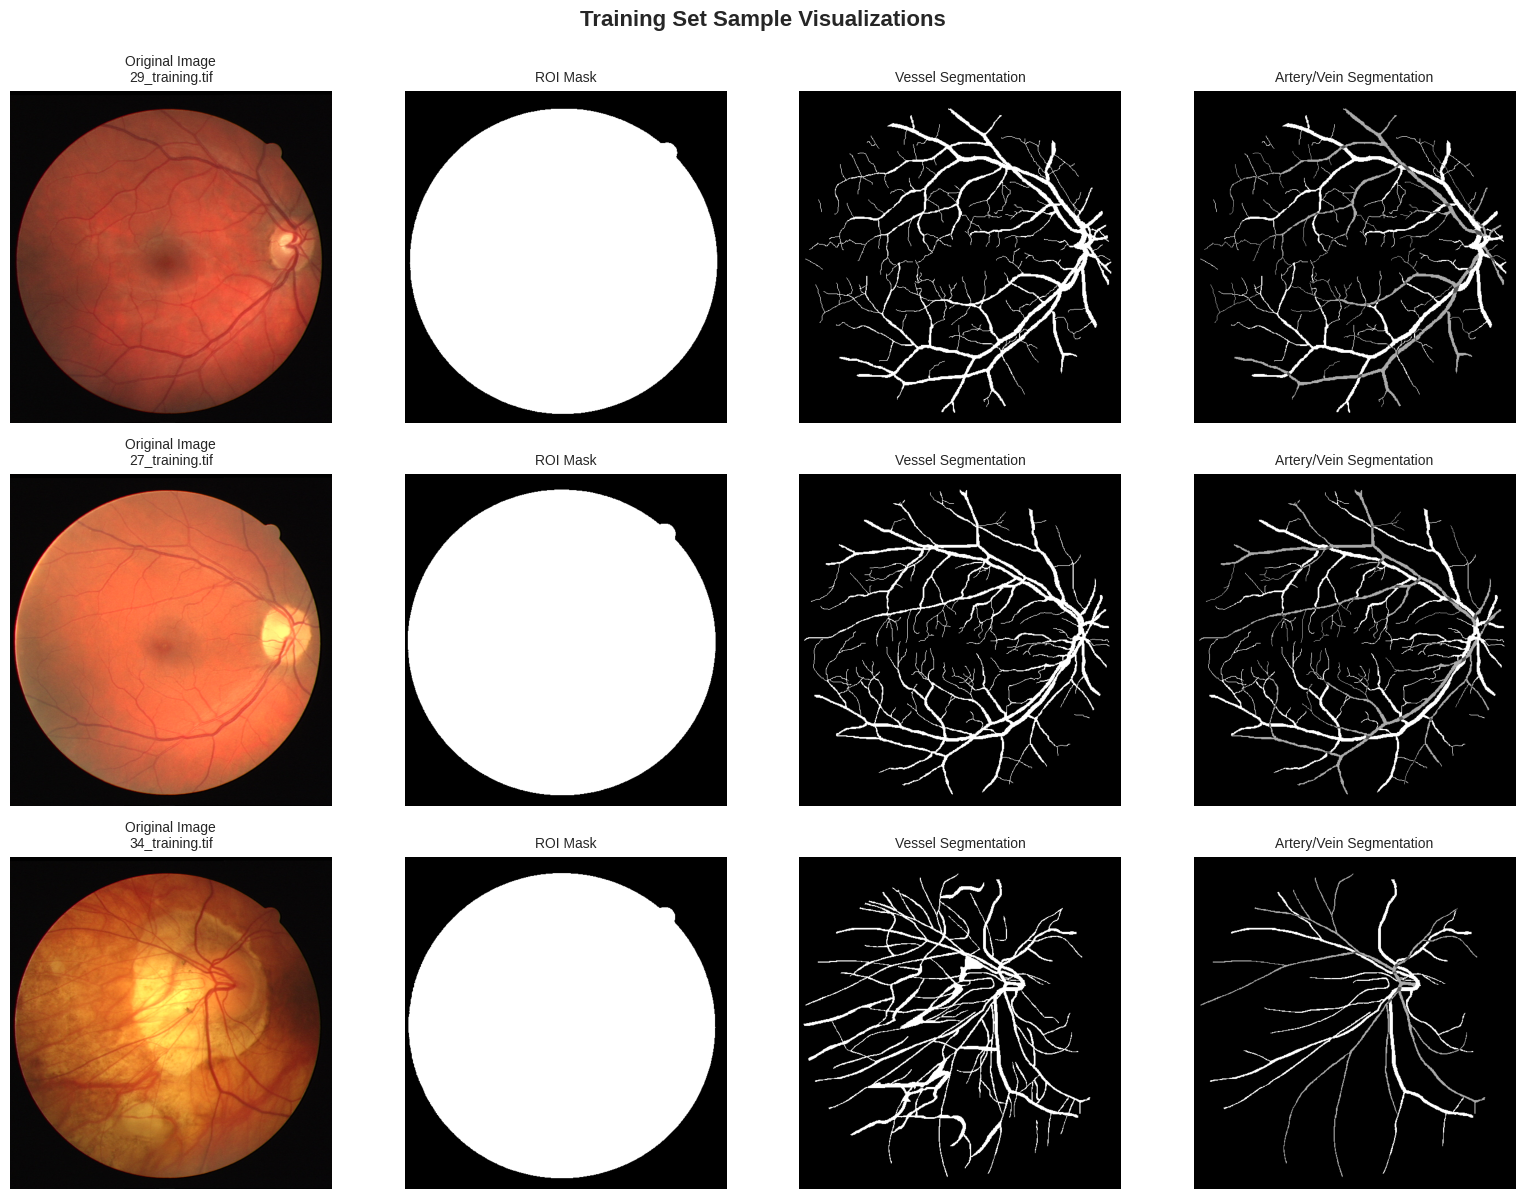

In [116]:
# Visualize sample images with masks and segmentations
def visualize_samples(df, num_samples=4, title_prefix=""):
    """Visualize sample images with their masks and segmentations"""
    samples = df.sample(min(num_samples, len(df)))
    
    fig, axes = plt.subplots(num_samples, 4, figsize=(16, num_samples * 4))
    if num_samples == 1:
        axes = axes.reshape(1, -1)
    
    for idx, (_, row) in enumerate(samples.iterrows()):
        # Load images
        img_path = BASE_DIR / row['im_paths']
        gt_path = BASE_DIR / row['gt_paths']
        mask_path = BASE_DIR / row['mask_paths']
        av_path = BASE_DIR / row['gt_paths_av']
    
        img = np.array(Image.open(img_path))
        gt = np.array(Image.open(gt_path))
        mask = np.array(Image.open(mask_path))
        av = np.array(Image.open(av_path))
        if len(av.shape) == 2:
            av = cv2.cvtColor(av, cv2.COLOR_GRAY2RGB)


        # Original image
        axes[idx, 0].imshow(img)
        axes[idx, 0].set_title(f'Original Image\n{Path(img_path).name}', fontsize=10)
        axes[idx, 0].axis('off')
        
        # ROI mask
        axes[idx, 1].imshow(mask, cmap='gray')
        axes[idx, 1].set_title('ROI Mask', fontsize=10)
        axes[idx, 1].axis('off')
        
        # Vessel segmentation
        axes[idx, 2].imshow(gt, cmap='gray')
        axes[idx, 2].set_title('Vessel Segmentation', fontsize=10)
        axes[idx, 2].axis('off')
        
        # Artery/Vein segmentation
        axes[idx, 3].imshow(av)
        axes[idx, 3].set_title('Artery/Vein Segmentation', fontsize=10)
        axes[idx, 3].axis('off')
        
        # # Overlay
        # overlay = img.copy()
        # if len(overlay.shape) == 2:
        #     overlay = cv2.cvtColor(overlay, cv2.COLOR_GRAY2RGB)
        # vessel_mask = (gt > 0)
        # overlay[vessel_mask] = [255, 0, 0]  # Red vessels
        # axes[idx, 3].imshow(overlay)
        # axes[idx, 3].set_title('Overlay (Red: Vessels)', fontsize=10)
        # axes[idx, 3].axis('off')
    
    plt.suptitle(f'{title_prefix} Sample Visualizations', fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()

# Visualize training samples
print("Visualizing TRAINING samples...")
visualize_samples(df_train_all, num_samples=3, title_prefix="Training Set")

Visualizing VAL samples...


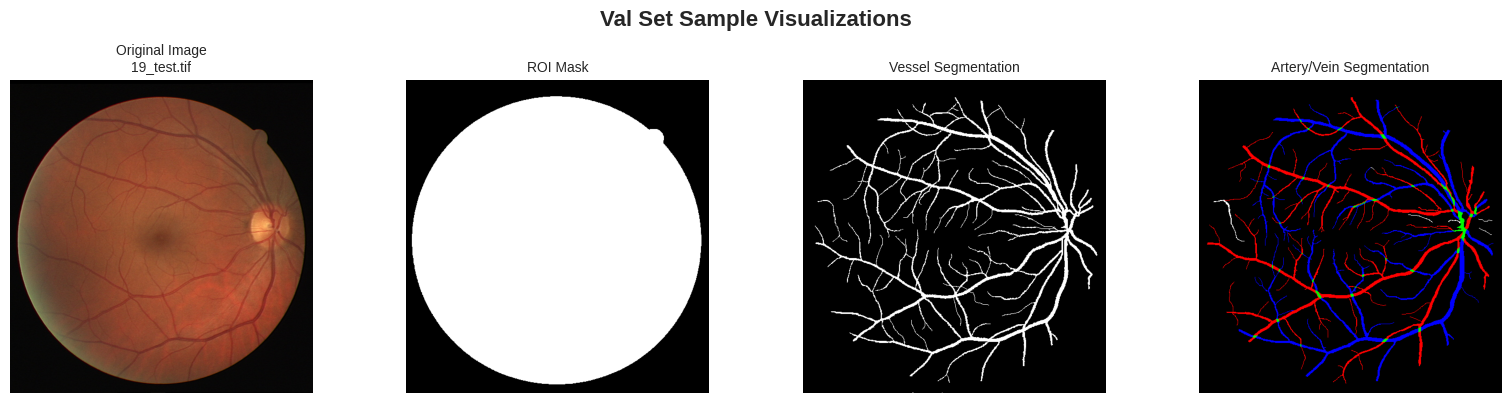

In [117]:
# Visualize test samples
print("Visualizing VAL samples...")
visualize_samples(df_test_all, num_samples=1, title_prefix="Val Set")

Visualizing TEST samples...


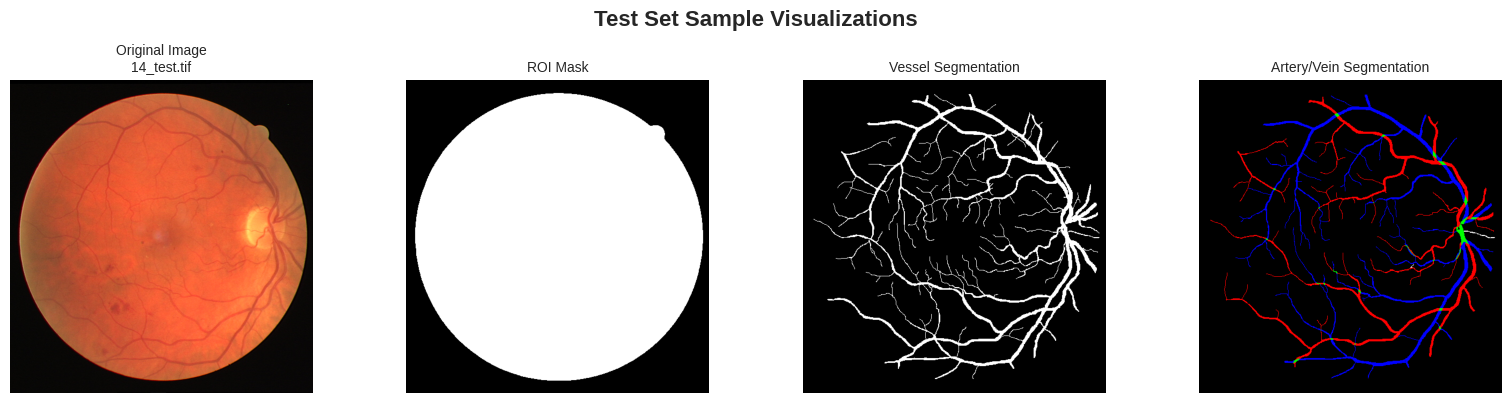

In [118]:
# Visualize test samples
print("Visualizing TEST samples...")
visualize_samples(df_test_all, num_samples=1, title_prefix="Test Set")

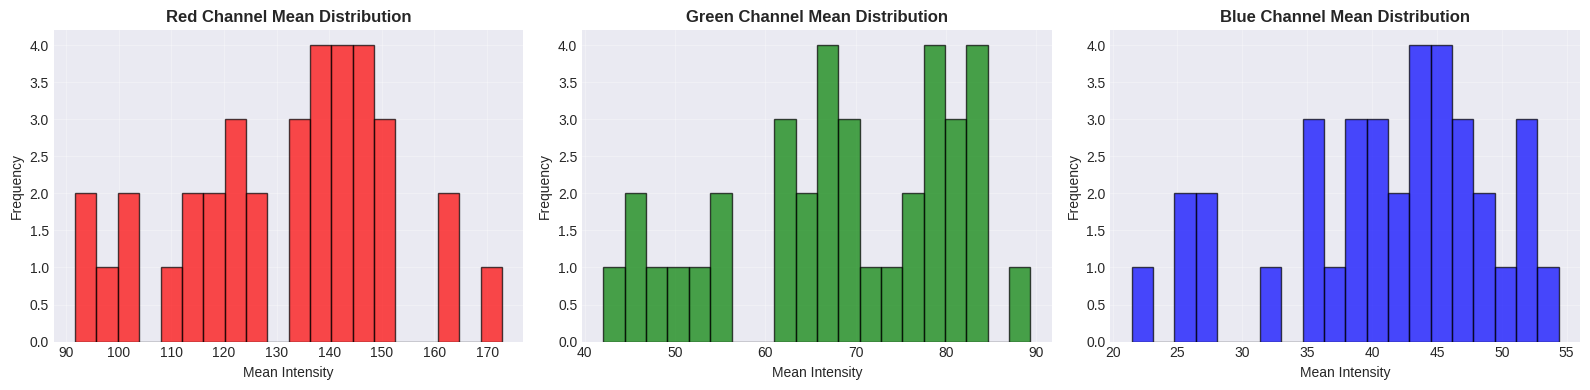


COLOR CHANNEL STATISTICS
Red Channel   - Mean: 131.71, Std: 19.61
Green Channel - Mean: 68.47, Std: 12.60
Blue Channel  - Mean: 40.99, Std: 8.17


In [119]:
# Analyze and visualize color channels
def analyze_color_channels(df, num_samples=None):
    """Analyze RGB color channel distributions"""
    r_means, g_means, b_means = [], [], []
    
    for idx, row in df.iterrows():
        img_path = BASE_DIR / row['im_paths']
        img = np.array(Image.open(img_path))
        if len(img.shape) == 3 and img.shape[2] == 3:
            r_means.append(img[:,:,0].mean())
            g_means.append(img[:,:,1].mean())
            b_means.append(img[:,:,2].mean())
    
    # Plot channel distributions
    fig, axes = plt.subplots(1, 3, figsize=(16, 4))
    
    axes[0].hist(r_means, bins=20, color='red', alpha=0.7, edgecolor='black')
    axes[0].set_title('Red Channel Mean Distribution', fontweight='bold')
    axes[0].set_xlabel('Mean Intensity')
    axes[0].set_ylabel('Frequency')
    axes[0].grid(alpha=0.3)
    
    axes[1].hist(g_means, bins=20, color='green', alpha=0.7, edgecolor='black')
    axes[1].set_title('Green Channel Mean Distribution', fontweight='bold')
    axes[1].set_xlabel('Mean Intensity')
    axes[1].set_ylabel('Frequency')
    axes[1].grid(alpha=0.3)
    
    axes[2].hist(b_means, bins=20, color='blue', alpha=0.7, edgecolor='black')
    axes[2].set_title('Blue Channel Mean Distribution', fontweight='bold')
    axes[2].set_xlabel('Mean Intensity')
    axes[2].set_ylabel('Frequency')
    axes[2].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print("\n" + "="*80)
    print("COLOR CHANNEL STATISTICS")
    print("="*80)
    print(f"Red Channel   - Mean: {np.mean(r_means):.2f}, Std: {np.std(r_means):.2f}")
    print(f"Green Channel - Mean: {np.mean(g_means):.2f}, Std: {np.std(g_means):.2f}")
    print(f"Blue Channel  - Mean: {np.mean(b_means):.2f}, Std: {np.std(b_means):.2f}")

all_df = pd.concat([df_train, df_test])
analyze_color_channels(all_df)

## 11. Summary and Insights <a name="summary"></a>

In [120]:
print("\n" + "="*80)
print("DRIVE DATASET - KEY INSIGHTS AND SUMMARY")
print("="*80)

total = len(df_train) + len(df_val) + len(df_test)
train_pct = (len(df_train) / total) * 100
val_pct = (len(df_val) / total) * 100
test_pct = (len(df_test) / total) * 100

insights = f"""
📊 DATASET COMPOSITION:
   • Total images: {len(df_all_img_props)}
   • Training: {len(df_train)} ({train_pct:.1f}%)
   • Validation: {len(df_val)} ({val_pct:.1f}%)
   • Test: {len(df_test)} ({test_pct:.1f}%)

🖼️ IMAGE CHARACTERISTICS:
   • Dimensions: {df_all_img_props['width'].iloc[0]} x {df_all_img_props['height'].iloc[0]} pixels
   • Color mode: RGB (3 channels)
   • Average file size: {df_all_img_props['file_size_kb'].mean():.1f} KB
   • Pixel intensity range: [{df_all_img_props['min_value'].min():.0f}, {df_all_img_props['max_value'].max():.0f}]

🎯 SEGMENTATION PROPERTIES:
   • Average ROI coverage: {df_all_mask_props['roi_percentage'].mean():.2f}%
   • Average vessel coverage: {df_all_vessel['vessel_percentage'].mean():.2f}%
   • Class imbalance ratio: {avg_background_pct/avg_vessel_pct:.2f}:1 (Background:Vessel)

⚖️ CLASS IMBALANCE:
   • Vessel pixels: ~{avg_vessel_pct:.2f}%
   • Background pixels: ~{avg_background_pct:.2f}%
   • ⚠️ Highly imbalanced - consider using weighted loss or focal loss

💡 RECOMMENDATIONS:
   1. Use data augmentation (rotation, flipping, elastic deformation)
   2. Apply class weighting or focal loss to handle imbalance
   3. Consider CLAHE preprocessing for better contrast
   4. Use green channel - typically has best vessel contrast
   5. Apply proper normalization based on observed intensity ranges
   6. Use metrics beyond accuracy (Dice, IoU, F1-score)

✅ DATA QUALITY:
   • All images have consistent dimensions
   • All referenced files exist
   • No duplicate files across splits
   • Pixel values in valid range
"""

print(insights)
print("="*80)


DRIVE DATASET - KEY INSIGHTS AND SUMMARY

📊 DATASET COMPOSITION:
   • Total images: 40
   • Training: 16 (40.0%)
   • Validation: 4 (10.0%)
   • Test: 20 (50.0%)

🖼️ IMAGE CHARACTERISTICS:
   • Dimensions: 565 x 584 pixels
   • Color mode: RGB (3 channels)
   • Average file size: 723.2 KB
   • Pixel intensity range: [0, 255]

🎯 SEGMENTATION PROPERTIES:
   • Average ROI coverage: 68.79%
   • Average vessel coverage: 8.69%
   • Class imbalance ratio: 10.50:1 (Background:Vessel)

⚖️ CLASS IMBALANCE:
   • Vessel pixels: ~8.69%
   • Background pixels: ~91.31%
   • ⚠️ Highly imbalanced - consider using weighted loss or focal loss

💡 RECOMMENDATIONS:
   1. Use data augmentation (rotation, flipping, elastic deformation)
   2. Apply class weighting or focal loss to handle imbalance
   3. Consider CLAHE preprocessing for better contrast
   4. Use green channel - typically has best vessel contrast
   5. Apply proper normalization based on observed intensity ranges
   6. Use metrics beyond accura

In [121]:
# Create a summary DataFrame
summary_data = {
    'Metric': [
        'Total Images',
        'Image Dimensions',
        'Train/Val/Test Split',
        'Avg Vessel Coverage (%)',
        'Avg ROI Coverage (%)',
        'Class Imbalance Ratio',
        'Avg File Size (KB)',
    ],
    'Value': [
        len(df_all_img_props),
        f"{df_all_img_props['width'].iloc[0]}x{df_all_img_props['height'].iloc[0]}",
        f"{len(df_train)}/{len(df_val)}/{len(df_test)}",
        f"{df_all_vessel['vessel_percentage'].mean():.2f}",
        f"{df_all_mask_props['roi_percentage'].mean():.2f}",
        f"{avg_background_pct/avg_vessel_pct:.2f}:1",
        f"{df_all_img_props['file_size_kb'].mean():.1f}",
    ]
}

df_summary = pd.DataFrame(summary_data)

print("\n" + "="*80)
print("QUICK REFERENCE SUMMARY")
print("="*80)
print(df_summary.to_string(index=False))
print("="*80)

print("\n✅ EDA Complete! The DRIVE dataset is ready for model training.")


QUICK REFERENCE SUMMARY
                 Metric   Value
           Total Images      40
       Image Dimensions 565x584
   Train/Val/Test Split 16/4/20
Avg Vessel Coverage (%)    8.69
   Avg ROI Coverage (%)   68.79
  Class Imbalance Ratio 10.50:1
     Avg File Size (KB)   723.2

✅ EDA Complete! The DRIVE dataset is ready for model training.
